In [26]:
import os
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

genai.configure(api_key = os.environ['GOOGLE_API_KEY'])

llm = genai.GenerativeModel(
    model_name='gemini-2.0-flash',
    )

In [27]:
res = llm.generate_content('What is the capital of France? and tell me the population and population ratio of the capital')

In [28]:
from IPython.display import Image, display, Markdown
display(Markdown(res.text))

The capital of France is **Paris**.

Here's some information about its population:

*   **Population:** As of 2023, the city of Paris (within its official boundaries) has an estimated population of around **2.1 million** people.

*   **Population Ratio:** When considering the broader metropolitan area of Paris (Île-de-France), the population is much larger, reaching approximately **13 million** people. This means the city of Paris itself represents roughly **16%** of the population of its metropolitan area.


In [29]:
from pydantic import BaseModel, Field
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=os.environ["GOOGLE_API_KEY"],
    max_output_tokens=1000,
    temperature=1,
    max_retries=3,
    timeout=10,
    verbose=True,
    )

class SearchQuery(BaseModel):
    search_query : str = Field(
        None, 
        description = "Query that is optimized web search."
    )
    justification : str = Field(
        None, description="Why this query is relevant to the user's request."
    )

In [30]:
structured_llm = llm.with_structured_output(SearchQuery)

output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

def multiply(a:int, b:int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("What is 2 times 3?")

msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': '682c8a2a-4c6c-41a7-919d-c6c508e25b3e',
  'type': 'tool_call'}]

In [31]:
import json

json.dumps(
    output.model_dump_json(),
    indent=2,
    ensure_ascii=False
    )

'"{\\"search_query\\":\\"calcium score high cholesterol relationship\\",\\"justification\\":\\"To find the relationship between Calcium CT score and high cholesterol.\\"}"'

In [32]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


workflow = StateGraph(State)

workflow.add_node('generate_joke', generate_joke)
workflow.add_node('improve_joke', improve_joke)
workflow.add_node('polish_joke', polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {"Fail" : "improve_joke", "Pass" : END}
)
workflow.add_edge('improve_joke', 'polish_joke')
workflow.add_edge('polish_joke', END)

chain = workflow.compile()

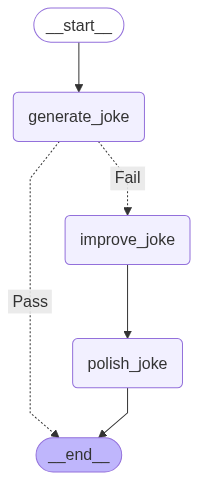

In [33]:
Image(chain.get_graph().draw_mermaid_png())

In [34]:
state = chain.invoke({
    'topic' : 'cats'
})

print('Initial Joke:')
print(state['joke'])
print('\n--- --- ---\n')
if "improved_joke" in state:
    print("Improved Joke:")
    print(state['improved_joke'])
    print('\n--- --- ---\n')

    print('Final Joke:')
    print(state['final_joke'])

else:
    print('Joke failed quality gate - no punchline detected!')

Initial Joke:
Why did the cat join the Red Cross? 

Because he wanted to be a first-aid kit! 

--- --- ---

Improved Joke:
Okay, here are a few options, playing with words related to cats, first aid, and the Red Cross:

**Option 1 (Focus on cat puns):**

Why did the cat join the Red Cross?

Because he wanted to be a **purr-amedic** and **mend** some broken spirits! He heard they needed a **cat-alyst** for healing.

**Option 2 (Focus on Red Cross and First Aid):**

Why did the cat join the Red Cross?

Because he wanted to be a first-aid **claw-set** organizer! He heard they were looking for someone to **paw-vide** emergency assistance! He wanted to be on the **front lines**... or at least on the **fur-ont lines**!

**Option 3 (More general silly wordplay):**

Why did the cat join the Red Cross?

Because he wanted to learn how to **bandage** his reputation as a couch potato! He heard they gave out **paw-some** certificates.

**Why these are funnier:**

*   **Wordplay/Puns:**  The additio

In [35]:
state

{'topic': 'cats',
 'joke': 'Why did the cat join the Red Cross? \n\nBecause he wanted to be a first-aid kit! ',
 'improved_joke': "Okay, here are a few options, playing with words related to cats, first aid, and the Red Cross:\n\n**Option 1 (Focus on cat puns):**\n\nWhy did the cat join the Red Cross?\n\nBecause he wanted to be a **purr-amedic** and **mend** some broken spirits! He heard they needed a **cat-alyst** for healing.\n\n**Option 2 (Focus on Red Cross and First Aid):**\n\nWhy did the cat join the Red Cross?\n\nBecause he wanted to be a first-aid **claw-set** organizer! He heard they were looking for someone to **paw-vide** emergency assistance! He wanted to be on the **front lines**... or at least on the **fur-ont lines**!\n\n**Option 3 (More general silly wordplay):**\n\nWhy did the cat join the Red Cross?\n\nBecause he wanted to learn how to **bandage** his reputation as a couch potato! He heard they gave out **paw-some** certificates.\n\n**Why these are funnier:**\n\n*   *

## Parallelization

In [38]:
class State(TypedDict):
    topic : str
    joke : str 
    story : str 
    poem : str 
    combined_output : str

def call_llm_1(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"""Write a joke about {state['topic']}""")
    return {'joke' : msg.content}

def call_llm_2(state:State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {'story' : msg.content}

def call_llm_3(state:State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {'poem' : msg.content}


def aggregator(state:State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {'combined_output':combined}

In [39]:
parallel_builder = StateGraph(State)

parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

parallel_builder.add_edge(START, 'call_llm_1')
parallel_builder.add_edge(START, 'call_llm_2')
parallel_builder.add_edge(START, 'call_llm_3')

parallel_builder.add_edge('call_llm_1', "aggregator")
parallel_builder.add_edge('call_llm_2', "aggregator")
parallel_builder.add_edge('call_llm_3', "aggregator")
parallel_builder.add_edge('aggregator', END)

parallel_workflow = parallel_builder.compile()

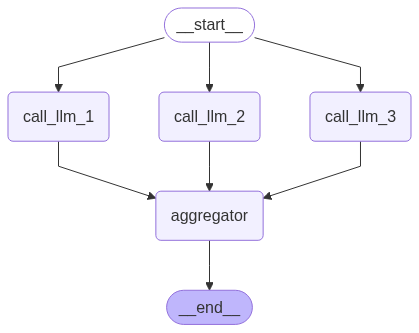

In [40]:
Image(parallel_workflow.get_graph().draw_mermaid_png())

In [41]:
state = parallel_workflow.invoke({'topic':'cats'})
print(state['combined_output'])

Here's a story, joke and poem about cats!

STORY:
The alley was a symphony of shadows and scents, a place where the city exhaled its secrets. Here, in the labyrinth of overflowing bins and crumbling brick, lived a tribe of cats, each a unique brushstroke on the canvas of feral life.

There was Marmalade, a ginger tomcat with one ear perpetually folded, the undisputed leader. He ruled with a gravelly meow and a surprisingly gentle paw, always ensuring the weakest got first dibs on the discarded scraps. Then there was Luna, a sleek black panther with eyes like molten gold. She was the hunter, the provider, disappearing into the night and returning with plump mice and the occasional unlucky pigeon.

And then there was Jasper, a skinny, calico kitten with oversized ears and a perpetually worried expression. He was new to the alley, abandoned in a cardboard box that reeked of cleaner and despair. He trembled constantly, overwhelmed by the cacophony of yowls and the pungent aroma of rotting 